# Сегментация полипов ЖКТ

[KvasirCapsule-SEG (capsule endoscopy dataset)](https://www.kaggle.com/datasets/debeshjha1/kvasircapsuleseg)

https://www.kaggle.com/datasets/debeshjha1/kvasircapsuleseg
Итоговое задание - выполнить сегментацию полипов согласно приложенного датасета.

1. подготовить данные должным образом.
2. Попробовать различные архитектуры, выбрать наилучшую.
3. Попробовать аугментацию, трансферное обучение.
4. Визуализировать предсказания выбранной модели.
5. Составить обобщающий хороший вывод.
6. (по желанию) сделать API


https://habr.com/ru/companies/otus/articles/442918/ - как делать API для ML

Сдавать как обычно Гитхаб или Гугл колаб.

In [1]:
try:
    from google.colab import drive
except ModuleNotFoundError as e:
    print(e)
else:
    drive.mount('/content/drive')
    !cp "/content/drive/MyDrive/Colab Notebooks/GB/MedML/4/utils.py" .
    !ls

No module named 'google.colab'


In [2]:
import numpy as np
import os

from PIL import Image
import matplotlib.pyplot as plt

import tensorflow as tf
from utils import UNet, ASPPNet

np.random.seed(42)

## Загрузка данных

In [ ]:
!wget https://gbcdn.mrgcdn.ru/uploads/asset/6044623/attachment/3cb884ce48bd701e5d5f369b872ef544.zip
!unzip archive.zip

## Визуализация данных

222
(336, 336, 3)


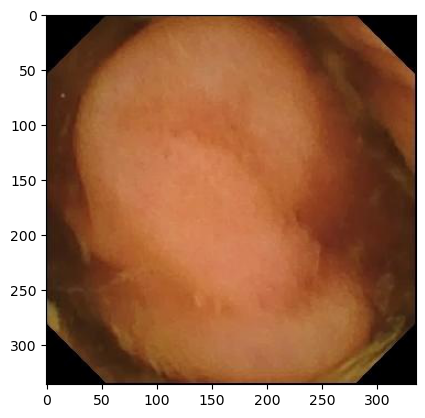

In [3]:
img = Image.open('Kvasir-Capsule/images/131368cc17e44240_28955.jpg')
img = np.array(img)
print(np.max(img))
print(img.shape)
img = img.astype(np.float32) / 255.
plt.imshow(img);

255
(336, 336)


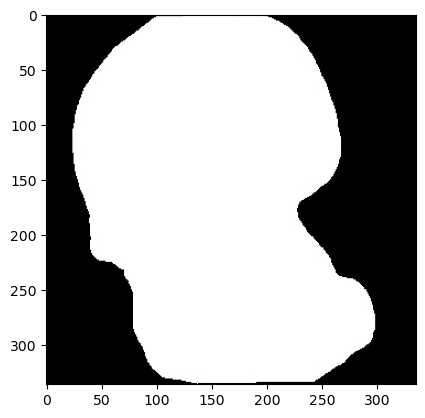

In [4]:
mask = Image.open('Kvasir-Capsule/masks/131368cc17e44240_28955.jpg')
mask = np.array(mask) 
print(np.max(mask))
print(mask.shape)
mask = mask.astype(np.float32) / 255.
plt.imshow(mask, cmap='gray');

## Создание сегментационного датасета

In [5]:
def load_images(img_dir: str) -> np.array:
    """Загрузка исходных изображений."""
    img_fnames = [f for f in os.listdir(img_dir) if os.path.isfile(os.path.join(img_dir, f))]

    images = []
    for fname in img_fnames:
        img = Image.open(f"{img_dir}/{fname}")
        img = img.resize((256, 256))
        img = np.array(img)
        img = img.astype(np.float32) / 255.
        images.append(img)
        # plt.imshow(img); break
    return np.array(images)

In [6]:
images = load_images("Kvasir-Capsule/images")
images.shape

(55, 256, 256, 3)

In [7]:
masks = load_images("Kvasir-Capsule/masks")
masks = masks[..., np.newaxis]
masks.shape

(55, 256, 256, 1)

In [8]:
# разбиение датасета на обучающую и тестовую выборки
# 5 изображений отберём для теста, остальные будут участвовать в обучении
idx = np.arange(len(images))
np.random.shuffle(idx)
train_idx, test_idx = idx[:-5], idx[-5:]
print(train_idx)
print(test_idx)

train_x, test_x = images[train_idx, :, :, :], images[test_idx, :, :, :]
train_y, test_y = masks[train_idx, :, :, :], masks[test_idx, :, :, :]

[31  5 32 13 19 49 41 26 43 12 52  3 33 34  8 17  6  4 47 27 46 45 53 15
  9 16 24 30 37 25 11  0 48 36 29 40  1 21  2 50 39 35 23 44 10 22 18 54
 20  7]
[42 14 28 51 38]


## Аугментация изображений

In [9]:
def image_augmentation(src: np.array) -> tuple:
    """Аугментация изображения."""
    # Повороты на 90 градусов
    rot90 = np.rot90(src)  # 90
    rot180 = np.rot90(rot90)  # 180
    rot270 = np.rot90(rot180)  # 270
    # Отражения
    fliplr = np.fliplr(src)  # слева направо
    flipud = np.flipud(src)  # сверху вниз
    return (src, rot90, rot180, rot270, fliplr, flipud)

def show_augment(src, rot90, rot180, rot270, fliplr, flipud):
    fig = plt.figure(figsize=(16, 9))
    ax1 = fig.add_subplot(1, 6, 1)
    ax1.set_xlabel('Source')
    plt.imshow(src);
    ax2 = fig.add_subplot(1, 6, 2)
    ax2.set_xlabel('Rotate 90')
    plt.imshow(rot90);
    ax3 = fig.add_subplot(1, 6, 3)
    ax3.set_xlabel('Rotate 180')
    plt.imshow(rot180);
    ax4 = fig.add_subplot(1, 6, 4)
    ax4.set_xlabel('Rotate 270')
    plt.imshow(rot270);
    ax5 = fig.add_subplot(1, 6, 5)
    ax5.set_xlabel('Flip left-right')
    plt.imshow(fliplr);
    ax6 = fig.add_subplot(1, 6, 6)
    ax6.set_xlabel('Flip up-down')
    plt.imshow(flipud);

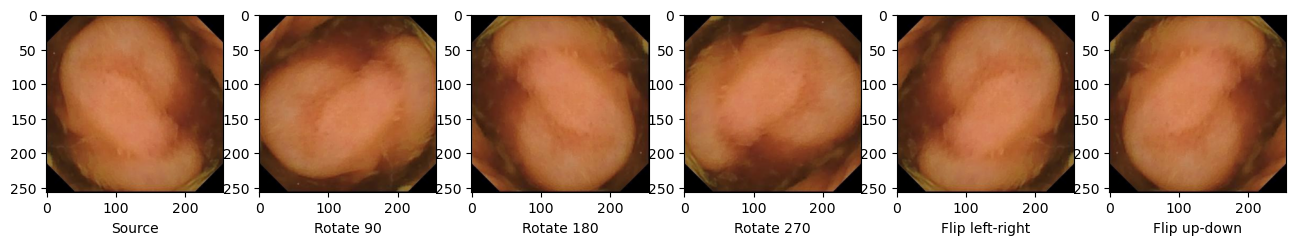

In [10]:
(src, rot90, rot180, rot270, fliplr, flipud) = image_augmentation(images[0])
show_augment(src, rot90, rot180, rot270, fliplr, flipud)

In [11]:
train_X, train_Y = [], []
for img, msk in zip(train_x, train_y):
    xs = image_augmentation(img)
    # show_augment(*xs)
    train_X.extend(xs)
    
    ys = image_augmentation(msk)
    # show_augment(*ys)
    train_Y.extend(ys)
    # break
train_X, train_Y = np.array(train_X), np.array(train_Y)
train_X.shape, train_Y.shape

((300, 256, 256, 3), (300, 256, 256, 1))

In [12]:
# перемешаем обучающую выборку
rnd_idx = np.arange(len(train_X))
np.random.shuffle(rnd_idx)
train_X, train_Y = train_X[rnd_idx, :, :, :], train_Y[rnd_idx, :, :, :]

## U-Net

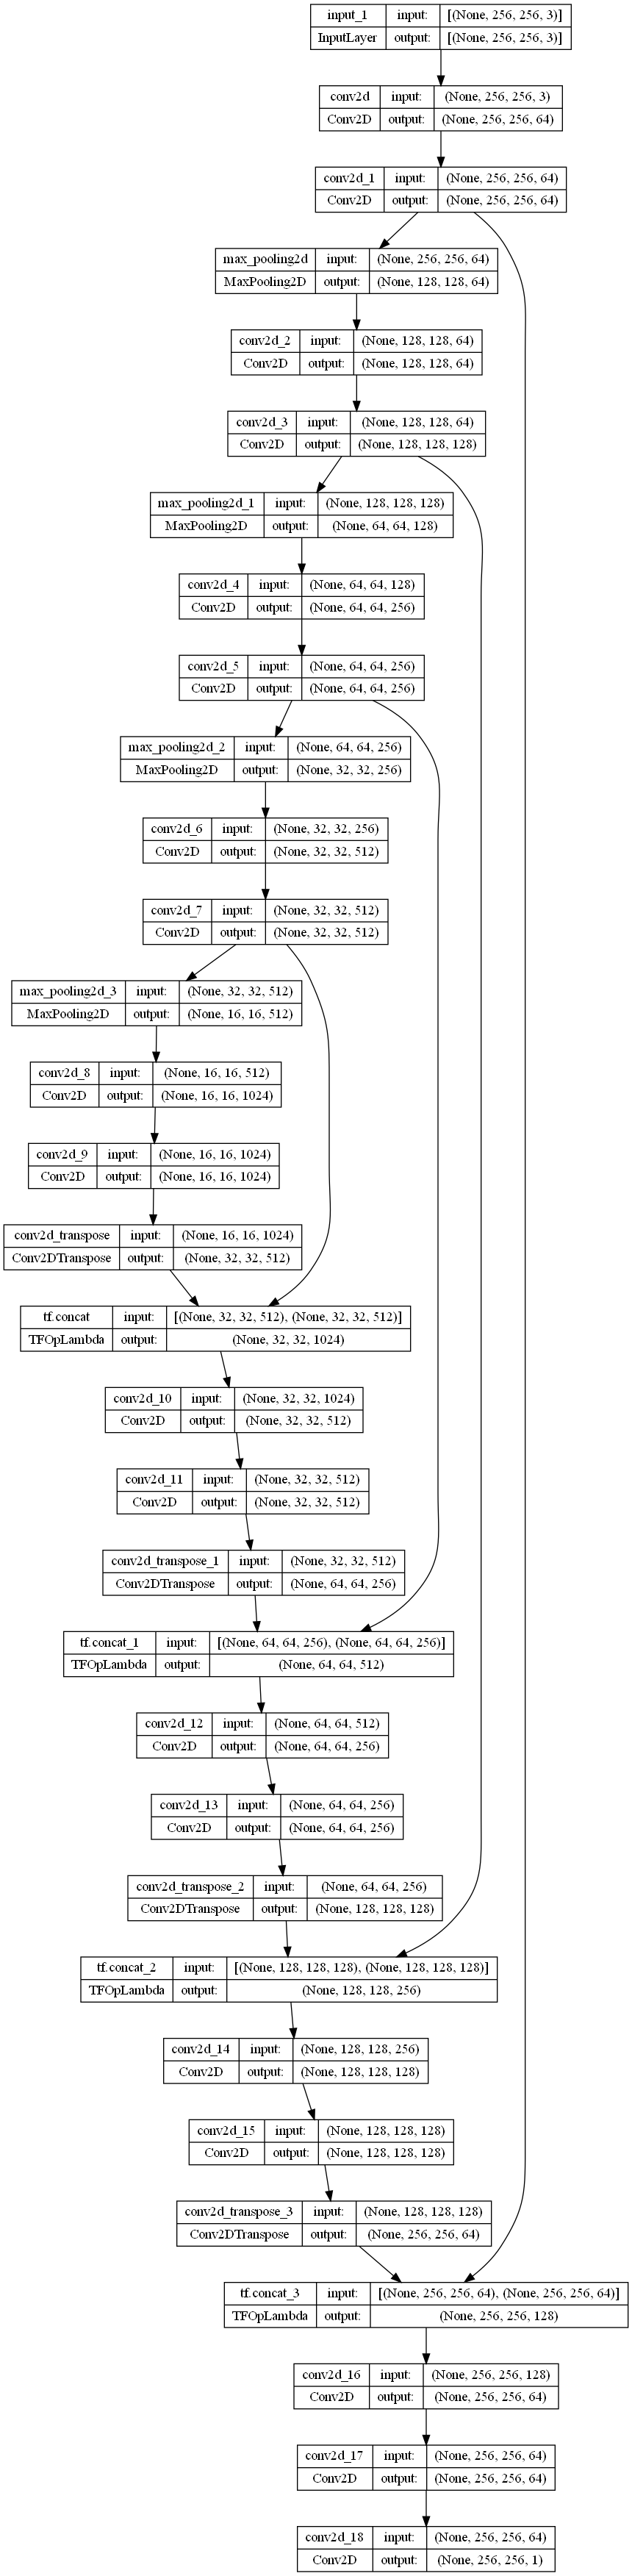

In [13]:
unet = UNet()
tf.keras.utils.plot_model(unet, show_shapes=True)

### Обучение модели

In [ ]:
NUM_EPOCHS = 100
BATCH_SIZE = 8

loss = tf.keras.losses.BinaryCrossentropy()
unet.compile(optimizer='adam', loss=loss)

unet_history = unet.fit(train_X, train_Y, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS)

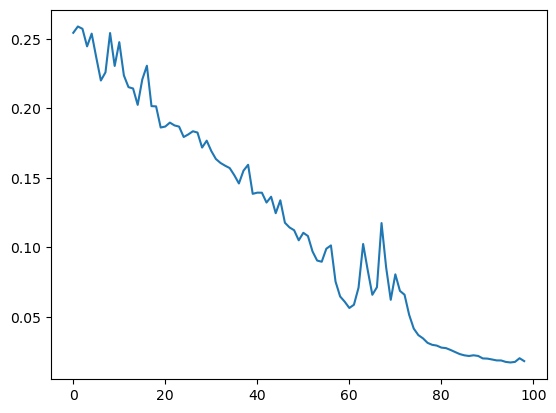

In [15]:
plt.plot(unet_history.history['loss'][1:]);

### Пример результата сегментации

In [16]:
def segmentation_example(model, img, msk):
    out = model.predict(img[None, ...])[0, ...]

    fig = plt.figure(figsize=(16, 9))

    ax1 = fig.add_subplot(1, 3, 1)
    ax1.set_xlabel('Image')
    plt.imshow(img)

    ax2 = fig.add_subplot(1, 3, 2)
    ax2.set_xlabel('Original mask')
    plt.imshow(msk, cmap='gray')

    ax3 = fig.add_subplot(1, 3, 3)
    ax3.set_xlabel('Predicted mask')
    plt.imshow(out[...,0], cmap='gray')

1/1 [==============================] - 2s 2s/step


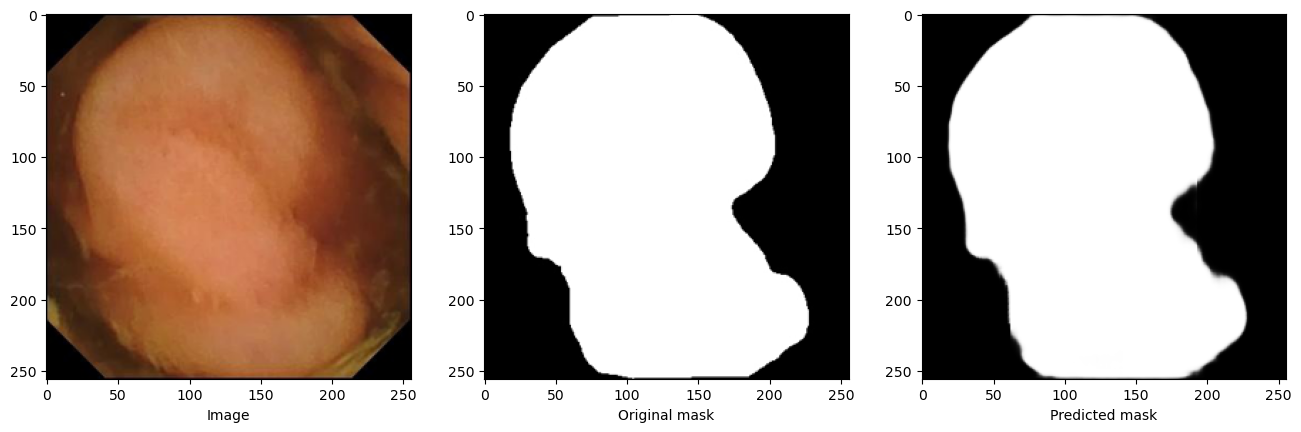

In [17]:
segmentation_example(unet, images[0], masks[0])

### Наложение маски сегментации на изображения

In [18]:
def mask_overlay(model):
    for sample, mask in zip(test_x, test_y):
        out = model.predict(sample[None, ...])
        seg_map = (out[0, ..., 0] > 0.5).astype(np.float32)
        seg_map_clr = plt.get_cmap('viridis')(seg_map)[..., :3]

        #plt.imshow(sample*0.5 + seg_map_clr*0.5)
        #plt.imshow(sample*seg_map[..., np.newaxis])

        fig = plt.figure(figsize=(16, 9))

        ax1 = fig.add_subplot(1, 4, 1)
        ax1.set_xlabel('Image')
        plt.imshow(sample)

        ax2 = fig.add_subplot(1, 4, 2)
        ax2.set_xlabel('Original mask')
        plt.imshow(mask, cmap='gray')

        ax3 = fig.add_subplot(1, 4, 3)
        ax3.set_xlabel('Predicted mask')
        plt.imshow(out[0, ..., 0], cmap='gray')

        ax4 = fig.add_subplot(1, 4, 4)
        ax4.set_xlabel('Overlay')
        plt.imshow(sample*seg_map[..., np.newaxis])
        # break

1/1 [==============================] - 0s 19ms/step


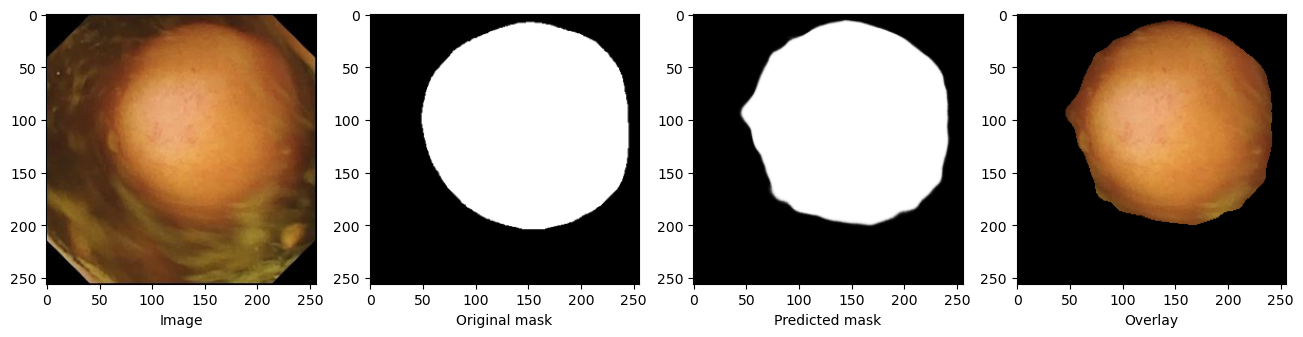

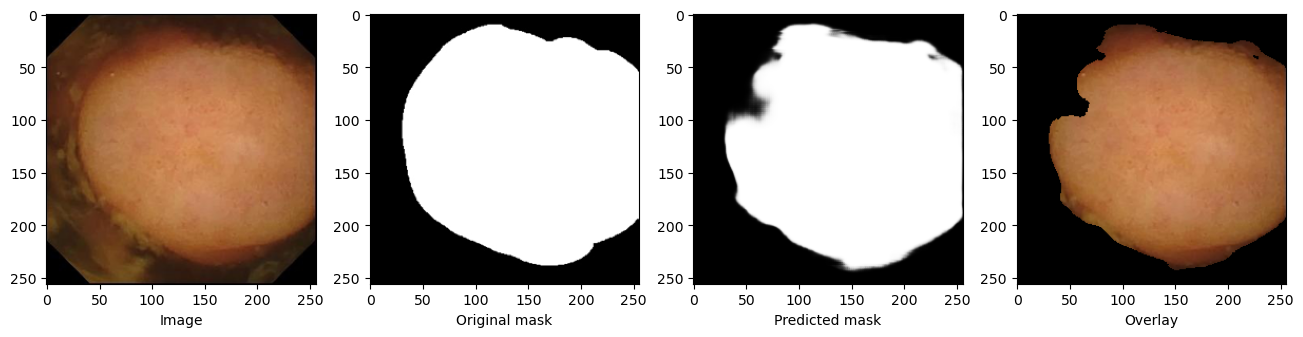

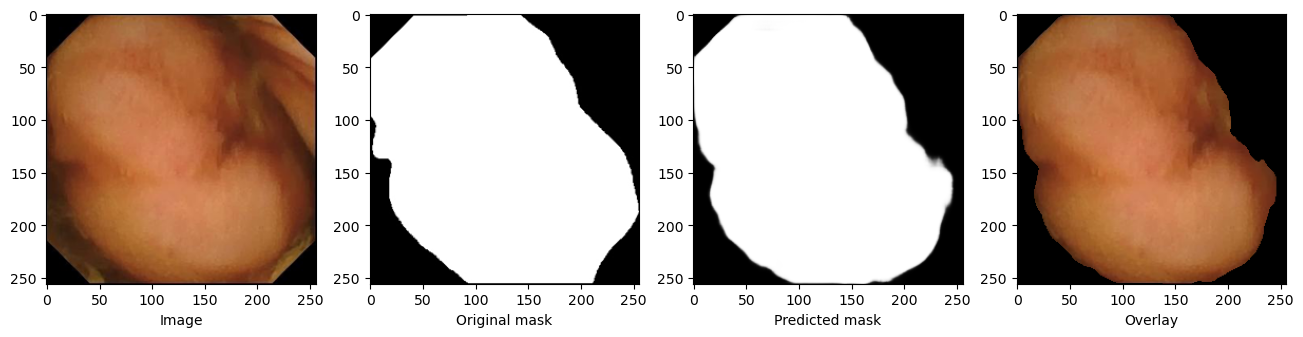

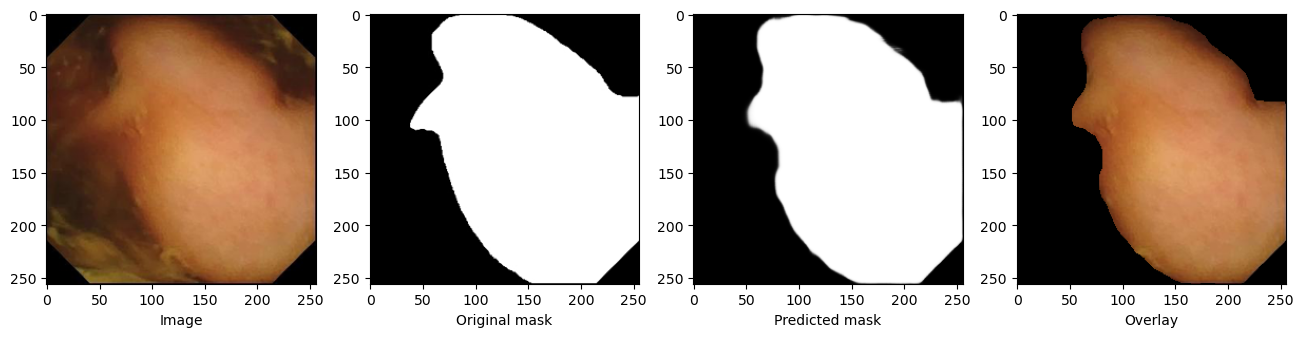

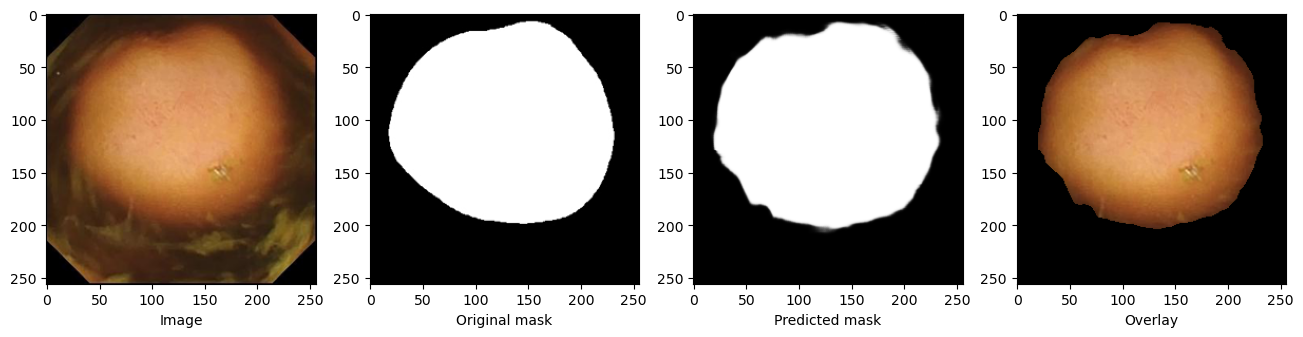

In [19]:
mask_overlay(unet)

## Atrous Spatial Pyramid Pooling (ASPP)

In [20]:
aspp = ASPPNet()

### Обучение модели

In [ ]:
NUM_EPOCHS = 100
BATCH_SIZE = 8

loss = tf.keras.losses.BinaryCrossentropy()
aspp.compile(optimizer='adam', loss=loss)

aspp_history = aspp.fit(train_X, train_Y, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS)

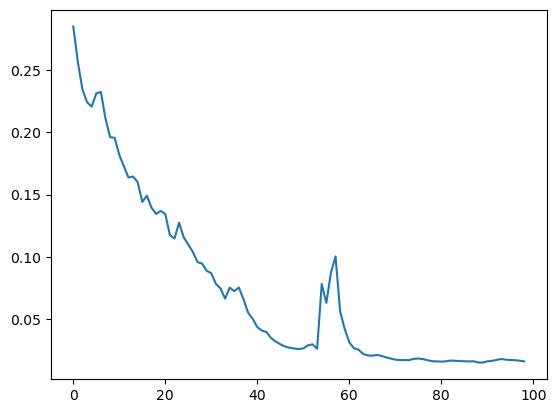

In [22]:
plt.plot(aspp_history.history['loss'][1:]);

### Пример результата сегментации

1/1 [==============================] - 1s 1s/step


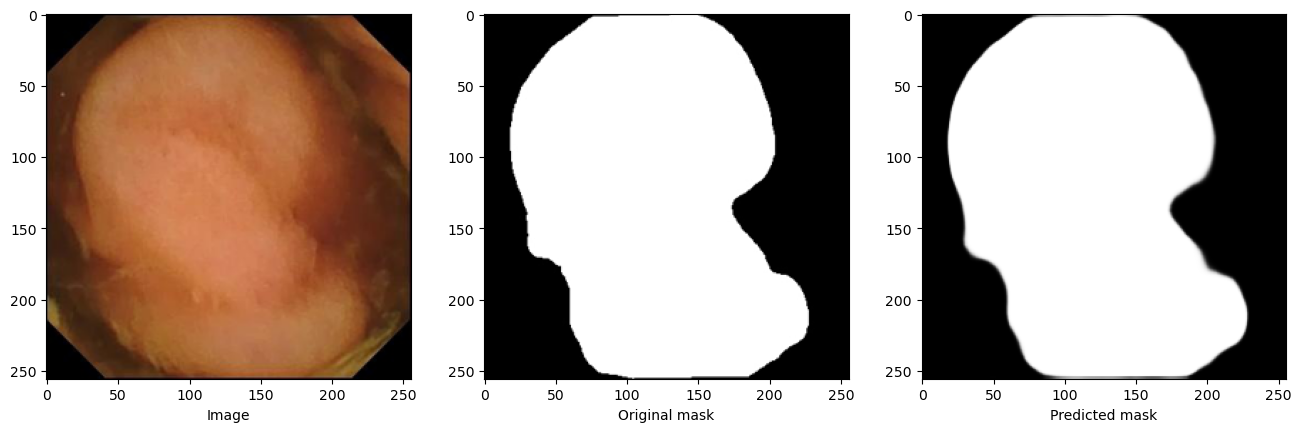

In [23]:
segmentation_example(aspp, images[0], masks[0])

### Наложение маски сегментации на изображения

1/1 [==============================] - 0s 20ms/step


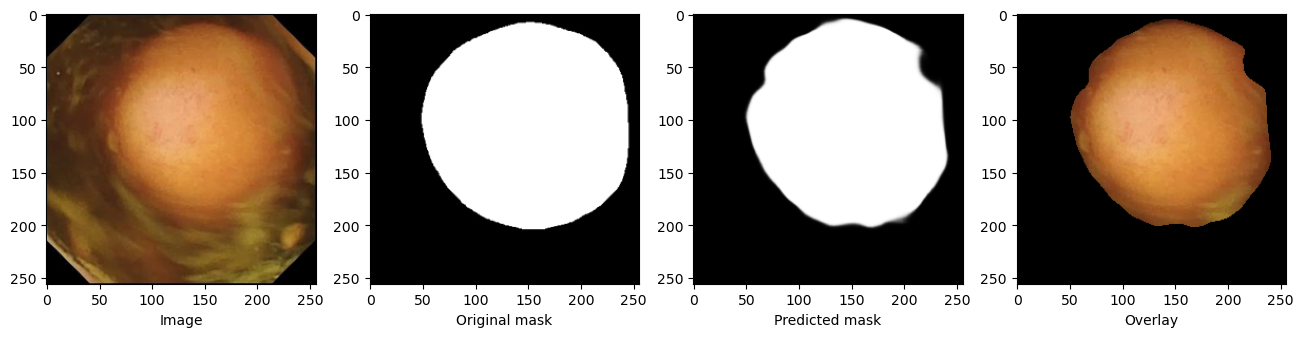

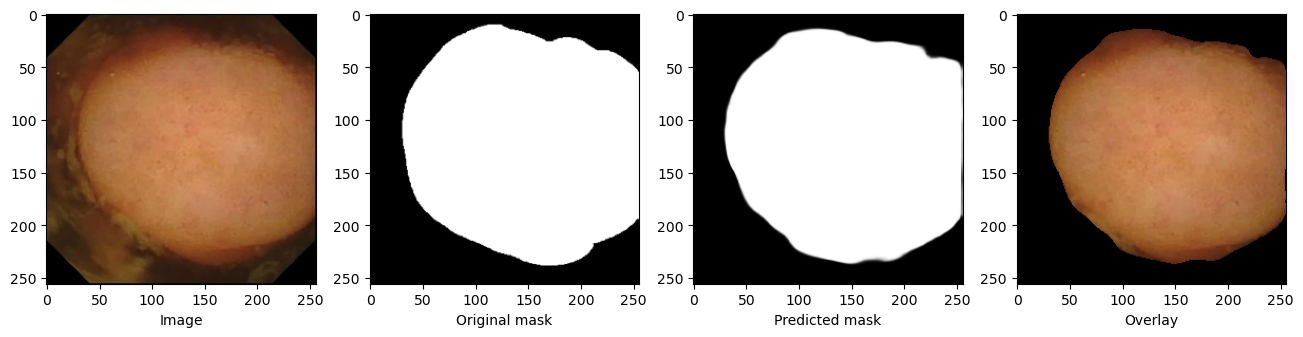

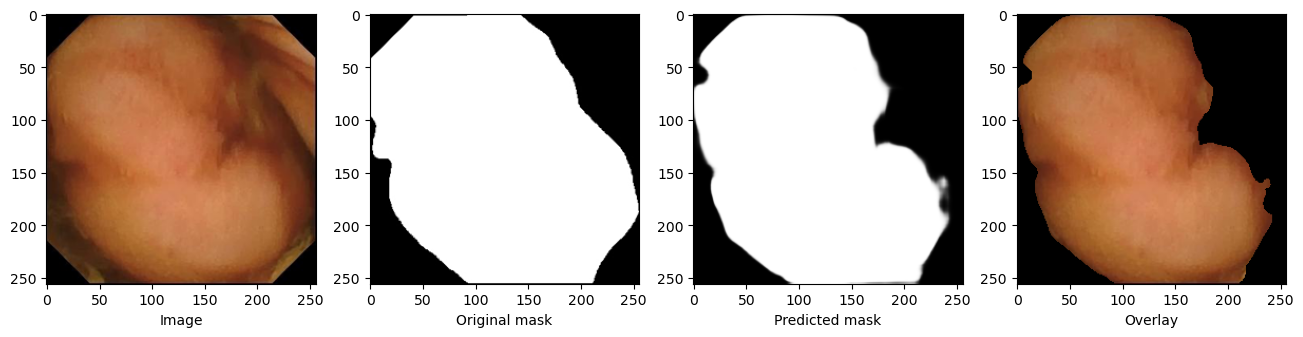

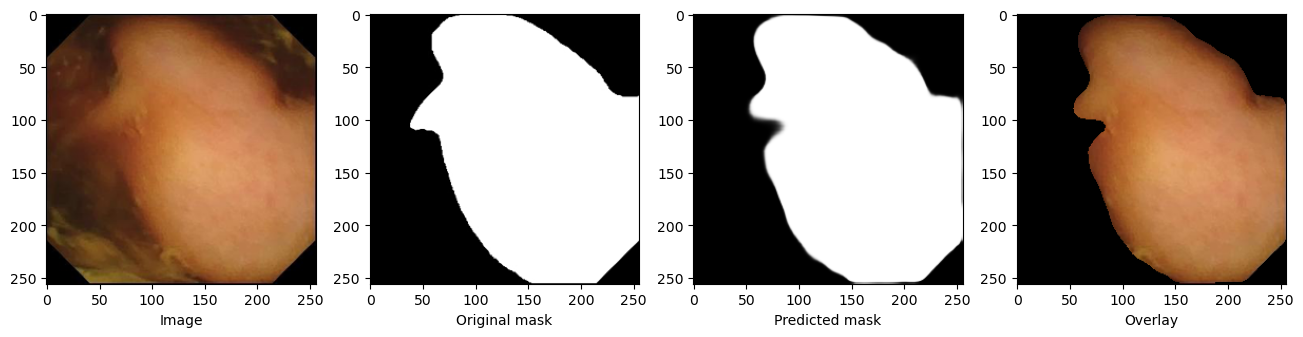

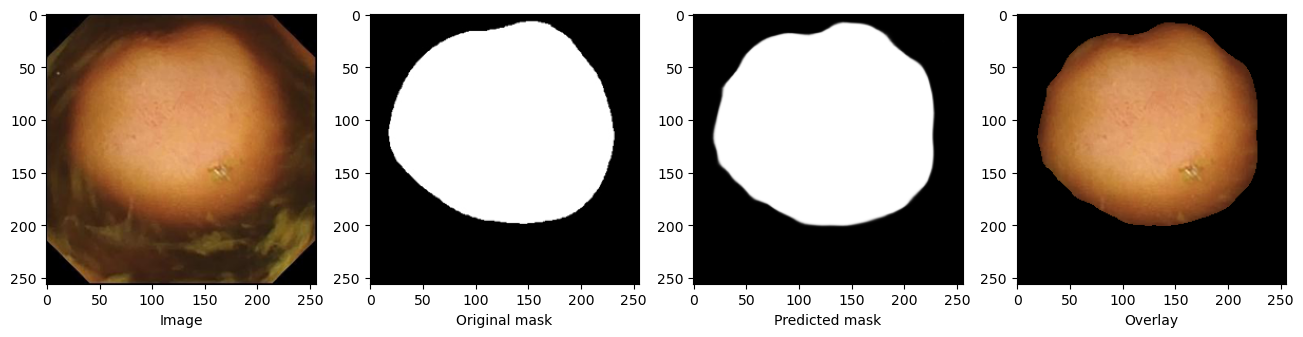

In [24]:
mask_overlay(aspp)

## Выводы:
- Вначале из исходного датасета были случайно отобраны 5 изображений, чтобы потом на них посмотреть результат обучения моделей.
- Обучающая выборка была подвержена аугментации: каждое изображение (вместе со своей маской) было подвергнуто следующим преобразованиям:
  - поворот на 90 градусов
  - поворот на 180 градусов
  - поворот на 270 градусов
  - отражение слева-направо
  - отражение сверху-вниз
  Полученные трансформации были добавлены к обучающей выборке.
- Были опробованы две архитектуры сегментации: **U-Net** и **Atrous Spatial Pyramid Pooling (ASPP)**. Наилучший результат показала модель ASPP:
  - у ASPP чуть более низкий loss (ASPP: 0.0161; U-Net: 0.0183)
  - процесс обучения у ASPP происходит почти в 2.5 раза быстрее, чем у U-Net
  - маски сегментации, предсказанные ASPP, имеют более чёткую и гладкую границу и меньше артефактов